# Train a deep CNN on XPS data on Google Colab

In this notebook, we will train a deep convolutional network on iron XPS spectra made up of linear combinations of single iron reference spectra.

## Setup

### Mount google drive, change working directory

In [1]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')

# Change working path
os.chdir('/content/drive/My Drive/app')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Install packages and import modules

In [2]:
# Install packages
!pip install python-docx

# Import standard modules and magic commands
import datetime
import numpy as np
import pytz
import importlib

# Magic commands
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Disable tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf

     |████████████████████████████████| 5.5MB 2.8MB/s 
  Created wheel for python-docx: filename=python_docx-0.8.10-cp36-none-any.whl size=184491 sha256=459c1bf8d79b48938045652488d307f86e6305b75eecdf4d2636b6f03e730cfd
  Stored in directory: /root/.cache/pip/wheels/18/0b/a0/1dd62ff812c857c9e487f27d80d53d2b40531bec1acecfa47b
Successfully built python-docx


## Classification

### Load custom modules

In [3]:
try:
    import importlib
    importlib.reload(classifier)
    importlib.reload(clfutils)
    print('Modules were reloaded.')
except:
    import xpsdeeplearning.network.classifier as classifier
    import xpsdeeplearning.network.utils as clfutils
    print('Modules were loaded.')

Modules were loaded.


### Set up the parameters & folder structure



In [9]:
np.random.seed(502)
time = '20200903_11h59m' #datetime.datetime.now().astimezone(pytz.timezone('Europe/Berlin')).strftime("%Y%m%d_%Hh%Mm")
data_name = 'Fe_multiple_4_classes_variable_linear_comb_Mark_gas_phase'
label_values = ['Fe metal', 'FeO', 'Fe3O4', 'Fe2O3']

clf = classifier.ClassifierMultiple(time = time,
                                    data_name = data_name,
                                    labels = label_values)

Model folder was already at /saved_models/20200903_11h59m_Fe_multiple_4_classes_variable_linear_comb_Mark_gas_phase
Logs folder was already at /logs/20200903_11h59m_Fe_multiple_4_classes_variable_linear_comb_Mark_gas_phase
Figures folder was already at /figures/20200903_11h59m_Fe_multiple_4_classes_variable_linear_comb_Mark_gas_phase


### Load and inspect the data

Data was loaded!
Total no. of samples: 99999
No. of training samples: 63999
No. of validation samples: 16000
No. of test samples: 20000
Shape of each sample : 1121 features (X) + 4 labels (y)


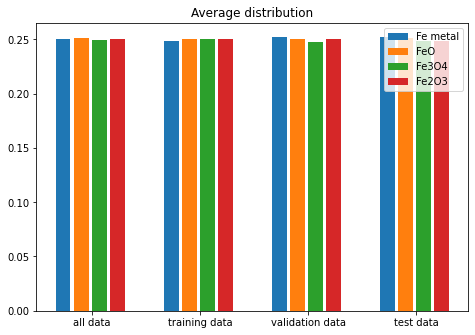

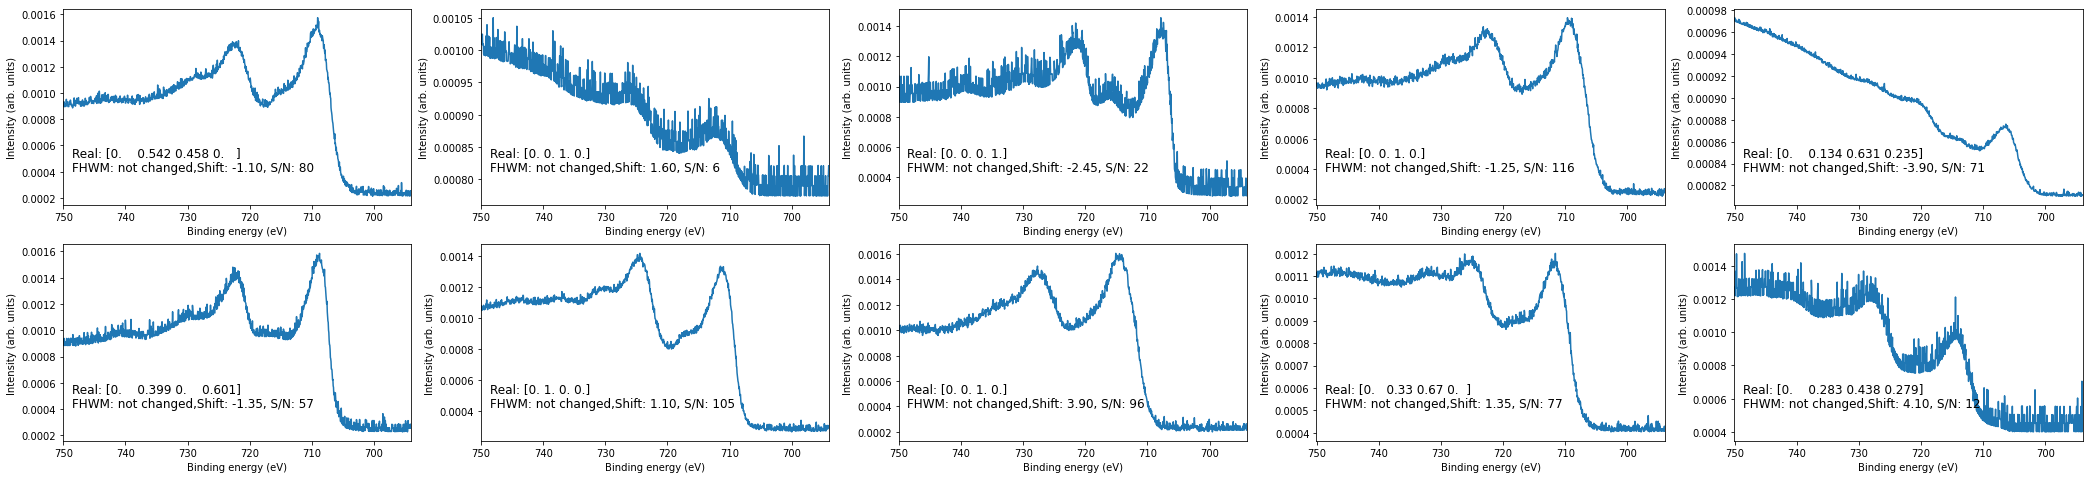

In [6]:
input_filepath = r'/content/drive/My Drive/app/datasets/20200902_iron_Mark_variable_linear_combination_gas_phase_100000.h5'
train_test_split = 0.2
train_val_split = 0.2
no_of_examples = 99999#100000

X_train, X_val, X_test, y_train, y_val, y_test,\
    aug_values_train, aug_values_val, aug_values_test =\
        clf.load_data_preprocess(input_filepath = input_filepath,
                                 no_of_examples = no_of_examples,
                                 train_test_split = train_test_split,
                                 train_val_split = train_val_split, 
                                 augmentation_values = True)
               
# Check how the examples are distributed across the classes.
class_distribution = clf.check_class_distribution()
clf.plot_class_distribution()
clf.plot_random(no_of_spectra = 10, dataset = 'train')  

### Design the model

In [ ]:
try:
    importlib.reload(models)
    print('Models module was reloaded.')
except:
    import xpsdeeplearning.network.models as models
    print('Models module was loaded.')

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, concatenate, Lambda
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import AveragePooling1D, MaxPooling1D
from tensorflow.keras.layers import LayerNormalization
from tensorflow.python.keras import backend as K

class CustomCNNMultiple(models.EmptyModel):
    def __init__(self, inputshape, num_classes):      
        input_1 = Input(shape = inputshape)
                
        conv_1_short = Conv1D(12, 5, padding = 'same',
                            activation = 'relu')(input_1)
        conv_1_medium = Conv1D(12, 10, padding = 'same',
                             activation = 'relu')(input_1)
        conv_1_long = Conv1D(12, 15, padding = 'same',
                           activation = 'relu')(input_1)
        sublayers = [conv_1_short, conv_1_medium, conv_1_long]
        merged_sublayers = concatenate(sublayers)
        
        conv_2 = Conv1D(10, 5, activation='relu')(merged_sublayers)
        conv_3 = Conv1D(10, 5, activation='relu')(conv_2)
        average_pool_1 = AveragePooling1D()(conv_3)
        
        flatten_1 = Flatten()(average_pool_1)
        drop_1 = Dropout(0.2)(flatten_1)
        dense_1 = Dense(4000, activation = 'relu')(drop_1)
        
        dense_2 = Dense(num_classes, activation = 'sigmoid')(dense_1)
        
        output = Lambda(lambda x: x/tf.reshape(K.sum(x, axis=-1),(-1,1)),
                        name = 'normalization')(dense_2)

        no_of_inputs = len(sublayers)

        super(CustomCNNMultiple, self).__init__(inputs = input_1,
                                                outputs = output,
                                                inputshape = inputshape,
                                                num_classes = num_classes,
                                                no_of_inputs = no_of_inputs,
                                                name = 'Custom_CNN_multiple')

### Build the model

In [ ]:
clf.model = CustomCNNMultiple(clf.input_shape, clf.num_classes)

# Alternative: Build model from available models
#clf.model = models.CustomCNNMultiple(clf.input_shape, clf.num_classes)

### Compile and summarize the model

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError

learning_rate = 1e-05
optimizer = Adam(learning_rate = learning_rate) 
mse = MeanSquaredError()
mae = MeanAbsoluteError()

# =============================================================================
# def custom_loss(y_true, y_pred):
#     """
#     Custom loss for linear combination of XPS spectra.
#     """
#     squared_difference = tf.square(tf.subtract(y_true,y_pred))
#     squared_output = tf.square(y_pred)
#     
#     return tf.reduce_sum(tf.multiply(squared_output,squared_difference))
# =============================================================================

# Compile model with build-in loss function
#clf.model.compile(loss = mse, optimizer = optimizer)
clf.model.compile(loss = mae, optimizer = optimizer)

# Plot summary and save model plot.
clf.summary()
clf.save_and_print_model_image()

### Show initial predictions

In [ ]:
pred_train_initial, pred_test_initial = clf.predict()

print(y_train[:5])
print(pred_train_initial[:5])

print(y_test[:5])
print(pred_test_initial[:5])

### Train

In [ ]:
epochs = 500
batch_size = 32

hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 epochs = epochs, 
                 batch_size = batch_size,
                 verbose = 1)

### Plot loss

In [ ]:
dir_name = clf.time + '_' + clf.data_name
graph = clfutils.TrainingGraphs(clf.history, dir_name)
graph.plot_loss()

### Evaluate on test data

In [ ]:
test_loss = clf.evaluate()
print('Test loss: ' + str(test_loss))

###  Predict on train and test data

In [ ]:
pred_train, pred_test = clf.predict()

### Show some predictions

#### 10 random training samples

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = 'train', with_prediction = True)  

#### 10 random test samples

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = 'test', with_prediction = True)  

### Show worst predictions

In [ ]:
clf.show_worst_predictions(no_of_spectra = 20)  

### Save model and data

In [ ]:
#clf.save_model()
clf.save_hyperparams()
clf.shelve_results(full = False)

### Generate report

In [ ]:
dir_name = clf.time + '_' + clf.data_name
rep = clfutils.Report(dir_name)  
rep.write()   

## Continue training

### Load custom modules

In [ ]:
try:
    import importlib
    importlib.reload(classifier)
    importlib.reload(clfutils)
    print('\n Modules were reloaded.')
except:
    import xpsdeeplearning.network.classifier as classifier
    import xpsdeeplearning.network.utils as clfutils
    print('\n Modules were loaded.')

### Set up the parameters & folder structure

In [ ]:
np.random.seed(502)
time = '20200709_18h10m'
#time = '20200707_16h30m' #datetime.datetime.now().astimezone(pytz.timezone('Europe/Berlin')).strftime("%Y%m%d_%Hh%Mm")
data_name = 'Fe_multiple_4_classes_variable_linear_comb'


label_values = ['Fe metal', 'FeO', 'Fe3O4', 'Fe2O3']

clf = classifier.ClassifierMultiple(time = time,
                                    data_name = data_name,
                                    labels = label_values)

### Load and inspect the data

In [ ]:
input_filepath = r'/content/drive/My Drive/app/datasets/20200708_iron_variable_linear_combination_500000.h5'
train_test_split = 0.2
train_val_split = 0.2
no_of_examples = 100000

X_train, X_val, X_test, y_train, y_val, y_test = \
        clf.load_data_preprocess(input_filepath = input_filepath,
                                 no_of_examples = no_of_examples,
                                 train_test_split = train_test_split,
                                 train_val_split = train_val_split)
        
# Check how the examples are distributed across the classes.
class_distribution = clf.check_class_distribution()
clf.plot_class_distribution()
clf.plot_random(no_of_spectra = 10, dataset = 'train')  

### Load the model

In [ ]:
clf.load_model()

### Compile and summarize the model

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError

learning_rate = 1e-05
optimizer = Adam(learning_rate = learning_rate) 
mse = MeanSquaredError()
mae = MeanAbsoluteError()
# =============================================================================
# def custom_loss(y_true, y_pred):
#     """
#     Custom loss for linear combination of XPS spectra.
#     """
#     squared_difference = tf.square(tf.subtract(y_true,y_pred))
#     squared_output = tf.square(y_pred)
#     
#     return tf.reduce_sum(tf.multiply(squared_output,squared_difference))
# =============================================================================

# Compile model with build-in loss function
#clf.model.compile(loss = mse, optimizer = optimizer)
clf.model.compile(loss = mae, optimizer = optimizer)

# Plot summary and save model plot.
clf.summary()
clf.save_and_print_model_image()

### Train

In [ ]:
epochs = 200
batch_size = 32

hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 epochs = epochs, 
                 batch_size = batch_size,
                 verbose = 1)

#new_learning_rate = 1e-04
# =============================================================================
# hist = clf.train(checkpoint = True,
#                  early_stopping = False,
#                  tb_log = True, 
#                  csv_log = True,
#                  epochs = epochs, 
#                  batch_size = batch_size,
#                  verbose = 1, 
#                  new_learning_rate = new_learning_rate)
# =============================================================================

In [ ]:
from tensorflow.keras import backend as K
print('New learning rate: ' +\
      str(K.eval(clf.model.optimizer.lr)))

### Plot loss

In [ ]:
dir_name = clf.time + '_' + clf.data_name
graph = clfutils.TrainingGraphs(clf.history, dir_name)
graph.plot_loss()

### Evaluate on test data

In [ ]:
test_loss = clf.evaluate()
print('Test loss: ' + str(test_loss))

###  Predict on train & test data

In [ ]:
pred_train, pred_test = clf.predict()

### Show some predictions

#### 10 random training samples

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = 'train', with_prediction = True)  

#### 10 random test samples

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = 'test', with_prediction = True)  

### Show worst predictions

In [ ]:
clf.show_worst_predictions(no_of_spectra = 20)  

### Save model and data

In [ ]:
#clf.save_model()
clf.save_hyperparams()
clf.shelve_results(full = False)

### Generate report

In [ ]:
dir_name = clf.time + '_' + clf.data_name
rep = clfutils.Report(dir_name)  
rep.write()   

## Save output of notebook

In [ ]:
from IPython.display import Javascript, display
from nbconvert import HTMLExporter

def save_notebook():
    display(Javascript("IPython.notebook.save_notebook()"),
            include=['application/javascript'])

def output_HTML(read_file, output_file):
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

import time
import os

time.sleep(20)
save_notebook()
print('Notebook saved!')
time.sleep(30)
current_file = '/content/drive/My Drive/app/xpsdeeplearning/train_multiple.ipynb'
output_file = os.path.join(clf.log_dir,'train_multiple_out.html')
output_HTML(current_file, output_file)
print('HTML file saved!')